In [1]:
!pip install tensorflow

In [2]:
import tensorflow.keras.backend as K
import keras

# Patch Keras to make sure swish works

# 🛠️ Fix for EfficientNet swish activation error:
# EfficientNet from 'efficientnet.keras' expects 'keras.backend.sigmoid' to exist,
# but it was removed in newer Keras versions. This patch avoids the AttributeError.
keras.backend.sigmoid = K.sigmoid

### Import libraries for pre-processing

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import keras
from keras.utils import to_categorical

### Function to read files present in the Python version of the dataset

In [4]:
def unpickle(file):
  with open(file, 'rb') as fo:
    myDict = pickle.load(fo, encoding='latin1')
  return myDict

### Upload in Colab

In [5]:
from google.colab import files
files.upload()

Saving cifar-100-python.tar.gz to cifar-100-python.tar.gz


### Extract the contents

In [6]:
import tarfile

# Extract to current directory
with tarfile.open("cifar-100-python.tar.gz", "r:gz") as tar:
    tar.extractall()

### Load training set

In [7]:
trainData = unpickle('cifar-100-python/train')

# type of items in each file
for item in trainData:
  print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


### Check length of the dataset

In [8]:
print(len(trainData['data']))
print(len(trainData['data'][0]))

50000
3072


So, there are 50,000 images in the training dataset and each image is a 3 channel 32 × 32 pixel image (32 × 32 × 3 = 3072).

Let us have a look at the unique fine labels.

In [9]:
print(np.unique(trainData['fine_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


So, there are 100 different fine labels for the images ranging from 0 to 99.

Let us now have a look at the unique coarse labels.

In [10]:
print(np.unique(trainData['coarse_labels']))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


So, there are 20 different coarse labels for the images ranging from 0 to 19.

Let us check what is there in the batch_label file.

In [11]:
print(trainData['batch_label'])

training batch 1 of 1


Here we have only one batch, so batch_label is a string stating that.

### Let us unpickle our test dataset and meta file.

In [12]:
testData = unpickle('cifar-100-python/test')

metaData = unpickle('cifar-100-python/meta')

#metaData
print("Fine labels:", metaData['fine_label_names'])
print("Coarse labels:", metaData['coarse_label_names'])

Fine labels: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', '

### Let us now create dataframes using the labels, which will help us in visualization

In [13]:
# storing coarse labels along with its number code in a dataframe
category = pd.DataFrame(metaData['coarse_label_names'], columns=['SuperClass'])

# storing fine labels along with its number code in a dataframe
subCategory = pd.DataFrame(metaData['fine_label_names'], columns=['SubClass'])

print(category)
print(subCategory)

                        SuperClass
0                  aquatic_mammals
1                             fish
2                          flowers
3                  food_containers
4             fruit_and_vegetables
5     household_electrical_devices
6              household_furniture
7                          insects
8                 large_carnivores
9    large_man-made_outdoor_things
10    large_natural_outdoor_scenes
11  large_omnivores_and_herbivores
12                  medium_mammals
13        non-insect_invertebrates
14                          people
15                        reptiles
16                   small_mammals
17                           trees
18                      vehicles_1
19                      vehicles_2
         SubClass
0           apple
1   aquarium_fish
2            baby
3            bear
4          beaver
..            ...
95          whale
96    willow_tree
97           wolf
98          woman
99           worm

[100 rows x 1 columns]


Let us now look at our data.

In [14]:
X_train = trainData['data']
X_train

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

<pre>
In order to perform the task of image recognition and classification, a
convolutional neural network has to be built which requires a 4D array as the
input. So, the data has to be transformed to acquire that shape.

(Number of instances × Width × Height × Depth)
</pre>

In [15]:
#4D array input for building the CNN model using Keras
X_train = X_train.reshape(len(X_train), 3, 32, 32).transpose(0, 2, 3, 1)

### Visualization:

Image number selected : 16699
Shape of image : (32, 32, 3)
Image category number: 2
Image category name: SuperClass    flowers
Name: 2, dtype: object
Image subcategory number: 70
Image subcategory name: SubClass    rose
Name: 70, dtype: object


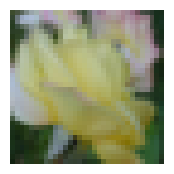

In [16]:
# generating a random number to display a random image from the dataset along with the label's number and name

# setting the figure size
rcParams['figure.figsize'] = 2,2

# generating a random number
imageId = np.random.randint(0, len(X_train))
imageId = 16699


# showing the image at that id
plt.imshow(X_train[imageId])

# setting axis display off for the image
plt.axis('off')

# displaying the image id
print("Image number selected : {}".format(imageId))

# displaying the shape of the image
print("Shape of image : {}".format(X_train[imageId].shape))

# displaying the category number
print("Image category number: {}".format(trainData['coarse_labels'][imageId]))

# displaying the category name
print("Image category name: {}".format(category.iloc[trainData['coarse_labels'][imageId]]))

# displaying the subcategory number
print("Image subcategory number: {}".format(trainData['fine_labels'][imageId]))

# displaying the subcategory name
print("Image subcategory name: {}".format(subCategory.iloc[trainData['fine_labels'][imageId]]))

Let us display some more images

<ipython-input-17-ce6eaea84837>:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i,j].set_title(subCategory.iloc[trainData['fine_labels'][imageId[k]]][0].capitalize())


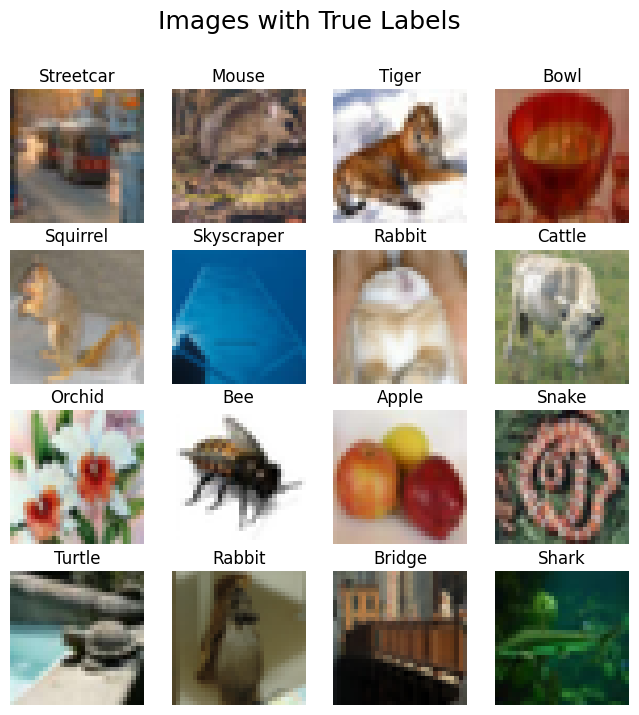

In [17]:
# 16 random images to display at a time along with their true labels

# setting the figure size
rcParams['figure.figsize'] = 8,8

# number of columns and rows in which images needs to be displayed
num_row = 4
num_col = 4

# to get 4 * 4 = 16 images together

imageId = np.random.randint(0, len(X_train), num_row * num_col)

# creating subplots
fig, axes = plt.subplots(num_row, num_col)

# main title of the plot
plt.suptitle('Images with True Labels', fontsize=18)

# displaying images as subplots
for i in range(0, num_row):
  for j in range(0, num_col):
    k = (i*num_col)+j
    axes[i,j].imshow(X_train[imageId[k]])
    axes[i,j].set_title(subCategory.iloc[trainData['fine_labels'][imageId[k]]][0].capitalize())
    axes[i,j].axis('off')

We can see from the visualization that the quality of images is low and the
position of the object in the image varies a lot. It would be difficult to
train a model to recognize and classify such images.

### Let us now work on the test dataset

In [18]:
# transforming the testing dataset
X_test = testData['data']
X_test = X_test.reshape(len(X_test), 3, 32, 32).transpose(0,2,3,1)

y_train = trainData['fine_labels']
y_test = testData['fine_labels']

In order to make predictions, the labels of the images have been converted to
categorical matrix structure from the existing 1D NumPy array structure.

In [19]:
# number of classes in the dataset
n_classes = 100

y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

### Model training using transfer learning

### Let us first import the libraries

In [20]:
!pip install opencv-python albumentations scikit-image numpy pandas matplotlib scikit-learn tensorflow keras efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.4 MB/s eta 0:00:00


In [21]:
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import albumentations as albu
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
!pip install -q efficientnet
import efficientnet.keras as efn

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


I have used stratified shuffle split to split my training set into training and
validation set because it will preserve the percentage of samples in each of
the 100 classes. Here is the code to perform splitting.

In [22]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=123)

for train_index, val_index in sss.split(X_train, y_train):
  X_train_data, X_val_data = X_train[train_index], X_train[val_index]
  y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Number of training samples: ", X_train_data.shape[0])
print("Number of validation samples: ", X_val_data.shape[0])

Number of training samples:  40000
Number of validation samples:  10000


As per EfficientNet, we need to not only scale the width and depth of the model
(which will be taken care by the pre-trained model) but the resolution of the
images as well. EfficientNet-B0 model architecture requires the image to be of
size (224, 224). So, let us resize our images of size (32, 32) to the new size.

In [23]:
height = 224
width = 224
channels = 3

input_shape = (height, width, channels)

The below function resize_img will take image and shape as the input and resize
each image. I have used the bicubic interpolation method to upscale the images.
It considers the closest 4 * 4 neighborhood of known pixels for a total of 16
pixels. This method produces noticeably sharper images and is considered an
ideal combination of processing time and output quality.

In [24]:
def resize_img(img, shape):
  return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

### Before writing the custom data generator class, let us first set our constants

In [25]:
n_classes = 100
epochs = 15
batch_size = 8

### Here is the code for the custom data generator class

In [26]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(height, width), channels=channels, n_classes=n_classes, shuffle=True, augment=False):

    # initializing the configuration of the generator
    self.images = images
    self.labels = labels
    self.mode = mode
    self.batch_size = batch_size
    self.dim = dim
    self.channels = channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.augment = augment
    self.on_epoch_end()

  # method to be called after every epoch
  def on_epoch_end(self):
    self.indexes = np.arange(self.images.shape[0])
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  # return numbers of steps in an epoch using samples & batch size
  def __len__(self):
    return int(np.floor(len(self.images) / self.batch_size))

  # this method is called with the batch number as an argument to obtain a given batch of data
  def __getitem__(self, index):
    # generate one batch of data
    # generate indexes of batch
    batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]

    # generate mini-batch of X
    X = np.empty((self.batch_size, *self.dim, self.channels))

    for i, ID in enumerate(batch_indexes):
      # generate pre-processed image
      img = self.images[ID]
      # image rescaling
      img = img.astype(np.float32)/255.
      # resizing as per new dimensions
      img = resize_img(img, self.dim)
      X[i] = img

    # generate mini-batch of y
    if self.mode == 'fit':
      y = self.labels[batch_indexes]

      # augmentation on the training dataset
      if self.augment == True:
        X = self.__augment_batch(X)
      return X, y

    elif self.mode == 'predict':
      return X

    else:
      raise AttributeError("The mode should be set to either 'fit' or 'predict'.")

  # augmentation for one image
  def __random_transform(self, img):
    composition = albu.Compose([
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.GridDistortion(p=0.2),
        albu.ElasticTransform(p=0.2)
    ])
    return composition(image=img)['image']

  # augmentation for batch of images
  def __augment_batch(self, img_batch):
    for i in range (img_batch.shape[0]):
      img_batch[i] = self.__random_transform(img_batch[i])
    return img_batch

### Let us apply the data generator class to our training and validation sets

In [27]:
train_data_generator = DataGenerator(X_train_data, y_train_data, augment=True)
valid_data_generator = DataGenerator(X_val_data, y_val_data, augment=False)

The EfficientNet class is available in Keras to help in Transfer Learning with
ease. I used the EfficientNet-B0 class with ImageNet weights. Since I used this
model just for feature extraction, I did not include the fully-connected layer
at the top of the network instead specified the input shape and pooling. I also added my own pooling and dense layers

### Here is the code to use the pre-trained EfficientNet-B0 model.

In [28]:
efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

model.summary()

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnet-b0 (Functional)    │ (None, 7, 7, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       128,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,177,664 (15.94 MB)

 Trainable params: 4,135,648 (15.78 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [29]:
optimizer = Adam(learning_rate=4.999999873689376e-05)

# early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

# reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

# model compiling
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### After compiling our model, let us fit it on our training dataset and validate it on the validation dataset.

In [30]:
model_history = model.fit(
    train_data_generator,
    validation_data = valid_data_generator,
    callbacks = [early_stop, rlrop],
    verbose = 1,
    epochs = epochs
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 331s 50ms/step - accuracy: 0.1533 - loss: 3.7964 - val_accuracy: 0.6330 - val_loss: 1.2974 - learning_rate: 5.0000e-05
Epoch 2/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 242s 48ms/step - accuracy: 0.4916 - loss: 1.8822 - val_accuracy: 0.7236 - val_loss: 0.9277 - learning_rate: 5.0000e-05
Epoch 3/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 244s 49ms/step - accuracy: 0.5908 - loss: 1.4718 - val_accuracy: 0.7612 - val_loss: 0.7950 - learning_rate: 5.0000e-05
Epoch 4/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 247s 49ms/step - accuracy: 0.6510 - loss: 1.2336 - val_accuracy: 0.7770 - val_loss: 0.7588 - learning_rate: 5.0000e-05
Epoch 5/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 243s 49ms/step - accuracy: 0.6897 - loss: 1.0676 - val_accuracy: 0.7953 - val_loss: 0.7168 - learning_rate: 5.0000e-05
Epoch 6/15
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 242s 48ms/step - accuracy: 0.7256 - loss: 0.9528 - val_accuracy: 0.7985 - val_loss: 0.7297 - learning_rate: 5.0000e-05
Epoch 7/15
5000/5000 ━━━━━━━━━━━━━

We can see that the model adjusted the learning rate on the 15th epoch and we
get a final accuracy of 85.20% on the training set, which is pretty good. But
wait, we need to look at the test accuracy too.

### Visualization helps to see things better. So, let's plot the accuracy and loss plots

In [31]:
# saving the trained model weights as data file in .h5 format
model.save_weights('cifar_efficientnetb0.weights.h5')

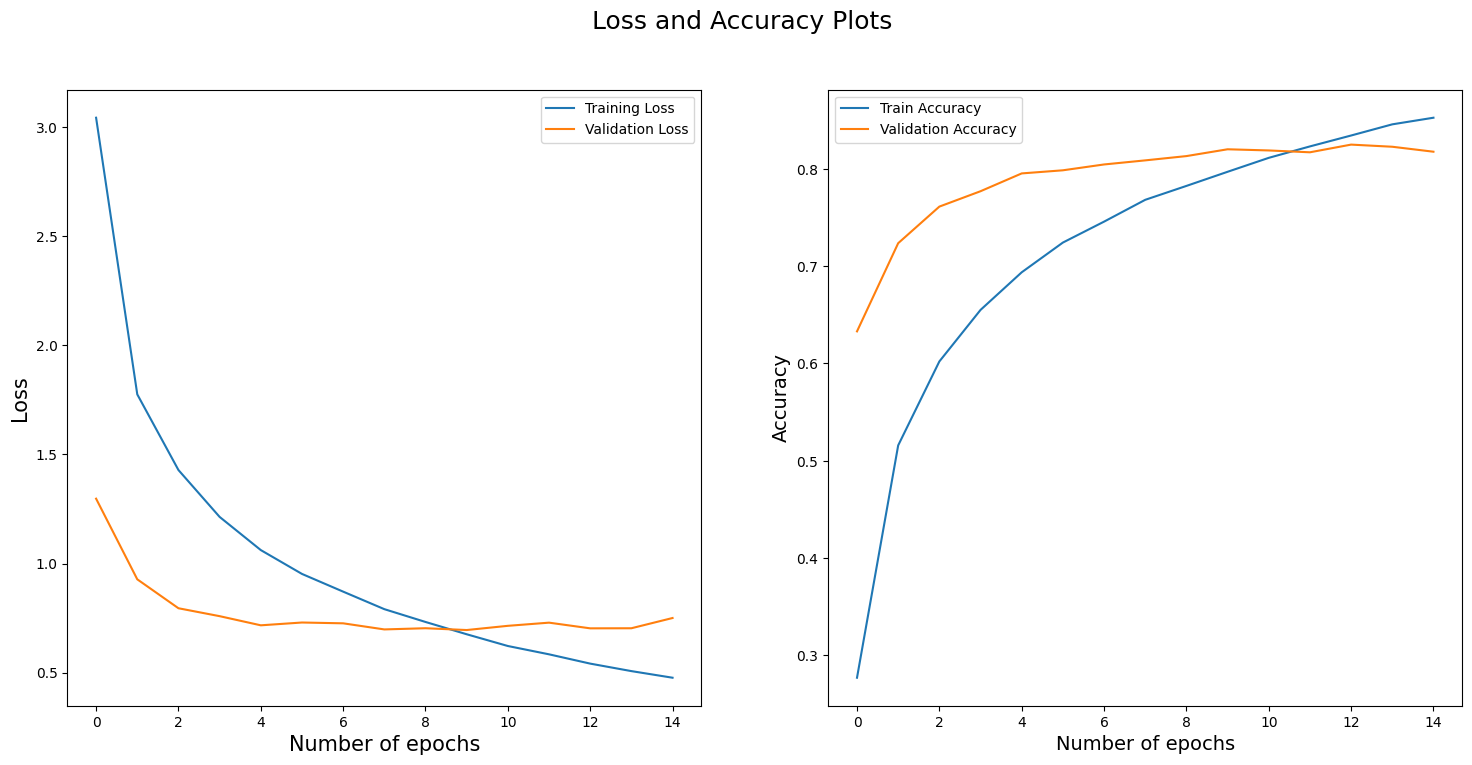

In [32]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

### Let us evaluate our model now

In [33]:
valid_loss, valid_accuracy = model.evaluate(valid_data_generator, verbose = 1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8161 - loss: 0.7180
Validation Accuracy:  82.01 %


### Now, it's time to look at the test dataset accuracy

In [34]:
y_pred = model.predict(DataGenerator(X_test, mode='predict', augment=False, shuffle=False), verbose=1)
y_pred = np.argmax(y_pred, axis=1)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step
Test Accuracy:  81.18 %


The results are pretty goood. We ggot an accuracy of 81.18% on the test dataset

### Confusion matrix and classification reports can be generated for the model using the following code

In [35]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)

target = ["Category {}".format(i) for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target))

[[100   0   0 ...   0   0   0]
 [  0  91   0 ...   0   0   0]
 [  0   0  73 ...   0   2   0]
 ...
 [  0   0   0 ...  80   0   0]
 [  0   0   2 ...   0  81   0]
 [  0   0   0 ...   0   0  81]]
              precision    recall  f1-score   support

  Category 0       0.85      1.00      0.92       100
  Category 1       0.91      0.91      0.91       100
  Category 2       0.65      0.73      0.69       100
  Category 3       0.68      0.69      0.68       100
  Category 4       0.70      0.66      0.68       100
  Category 5       0.77      0.81      0.79       100
  Category 6       0.89      0.87      0.88       100
  Category 7       0.89      0.78      0.83       100
  Category 8       0.94      0.97      0.96       100
  Category 9       0.87      0.90      0.89       100
 Category 10       0.76      0.56      0.64       100
 Category 11       0.62      0.45      0.52       100
 Category 12       0.90      0.82      0.86       100
 Category 13       0.86      0.75      0.80       1

### Visualize the predictions

<ipython-input-39-9ead02eceba2>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), fontsize=14)
<ipython-input-39-9ead02eceba2>:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), fontsize=14)
<ipython-input-39-9ead02eceba2

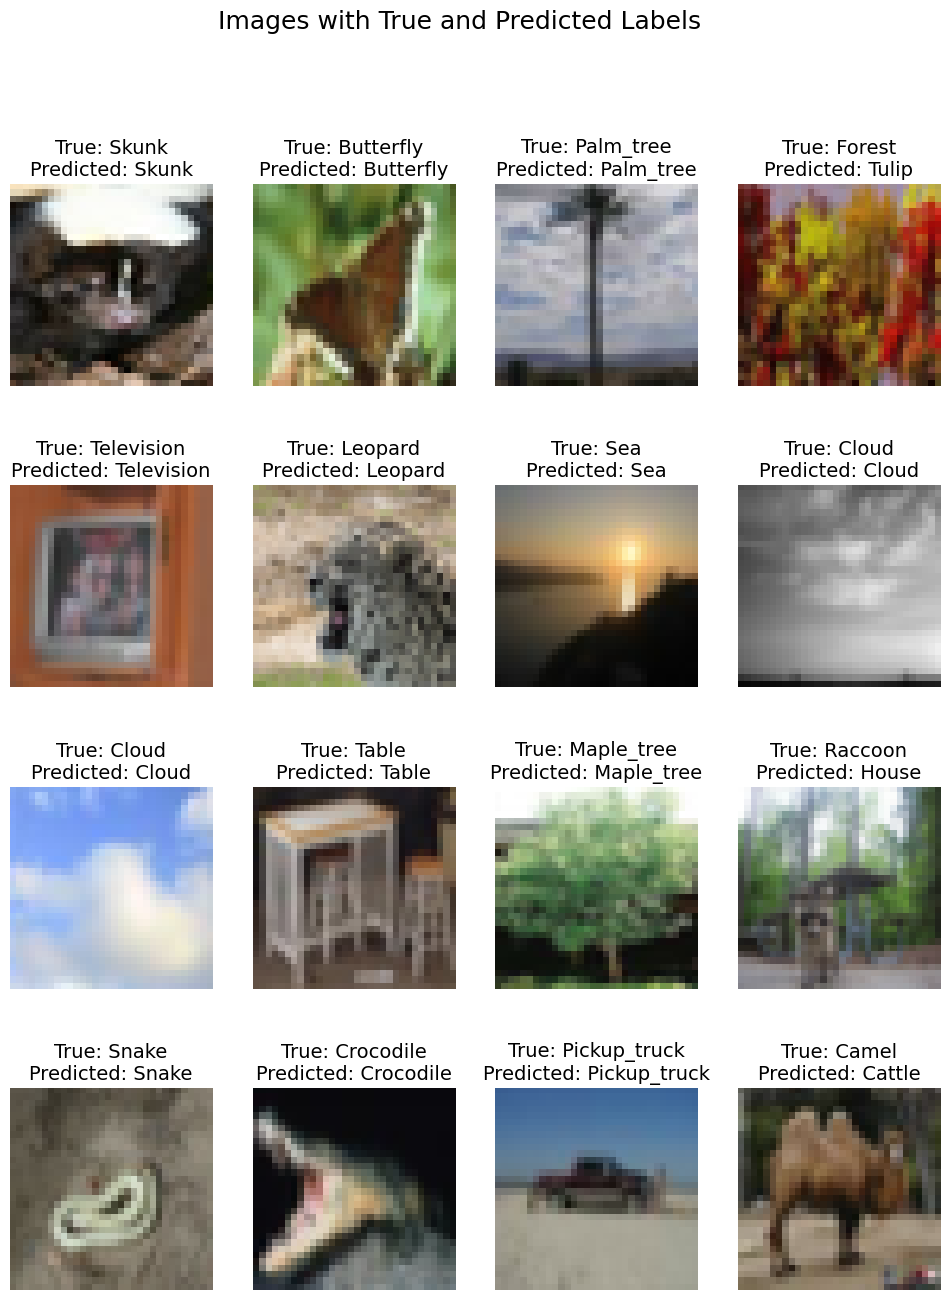

In [39]:
prediction = pd.DataFrame(y_pred)

rcParams['figure.figsize'] = 12, 15

num_row = 4
num_col = 4

fig, axes = plt.subplots(num_row, num_col)

imageId = np.random.choice(len(X_test), num_row * num_col, replace=False)

for i in range(0, num_row):
  for j in range(0, num_col):
    k = (i*num_col)+j
    axes[i,j].imshow(X_test[imageId[k]])
    axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), fontsize=14)
    axes[i,j].axis('off')
    fig.suptitle("Images with True and Predicted Labels", fontsize=18)
plt.show()

You can see that our model got confused between a camel and a cattle also
forest and tulip. But, we can see that most of the predictions were correct